#


# Evaluate fine-tuned ResNet50 on noisy test set


This is to evaluate the robustness of the fine-tuned models to noise. Without this, we only know how these fine-tuned models perform on the existing clean test set, but we don't know how it performs on noisy speech samples


In [1]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np
import random
import os
import sys
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
# Get the absolute path to the project root without relying on __file__
notebook_path = os.getcwd()  # Gets current working directory
project_root = os.path.abspath(os.path.join(notebook_path, "../.."))
sys.path.insert(0, project_root)

In [3]:
print(torch.__version__)
print(torch.cuda.is_available())

2.5.1+cu121
True


Set the seed for reproducability


In [4]:
random_seed = 42

torch.manual_seed(random_seed)
np.random.seed(random_seed)
random.seed(random_seed)

if (torch.cuda.is_available()):
    torch.cuda.manual_seed(random_seed)

Set some constant strings


In [5]:
test_csv = '../../../data/melspectrogram_test_dataset.csv'
root_dir = '../../../data/'
class_weights_path = '../../../data/class_weights.pt'

fine_tuned_weights = 'best_resnet50_224.pt'

Custom dataset class for loading the mel spectrogram images


In [6]:
from datasets.MelspectrogramDataset import MelSpectrogramDataset

Define the testing/evaluation function


In [7]:
def test(model, testloader, criterion, device):
    test_loss = 0.0
    test_total = 0
    test_correct = 0
    all_preds = []
    all_labels = []

    # Switch to evaluation mode
    model.eval()
    with torch.no_grad():
        for inputs, labels in tqdm(testloader, desc="Evaluating"):
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            # Get predictions
            _, predicted = torch.max(outputs, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()

            # Save predictions and labels for later use
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    test_loss = test_loss / len(testloader)
    test_accuracy = test_correct / test_total * 100

    return test_loss, test_accuracy, all_preds, all_labels

Define a class to add Gaussian noise to the test mel spectrograms


In [8]:
from data_augmentation.AddGaussianNoise import AddGaussianNoise

Define the model


In [9]:
# We don't load ImageNet weights here since we'll load our fine-tuned weights
model = models.resnet50(pretrained=False)

c:\Users\profi\OneDrive\Desktop\AI-Project--Speech-Emotion-Recognition\myenv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\profi\OneDrive\Desktop\AI-Project--Speech-Emotion-Recognition\myenv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Add Gaussian noise to the test set


In [10]:
test_transform = transforms.Compose([
    transforms.ToTensor(),
    AddGaussianNoise(noise_factor_range=(0.2, 0.2)  # Fixed noise factor
                     ),  # Use a fixed noise level
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

Define test set, test loader, and device


In [11]:
testset = MelSpectrogramDataset(
    csv_file=test_csv, root_dir=root_dir, transform=test_transform)
testloader = DataLoader(testset, batch_size=128,
                        shuffle=False, num_workers=8, pin_memory=True)

# Set device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Define the function to plot the confusion matrix


In [12]:
import seaborn as sns
from sklearn.metrics import confusion_matrix


def plot_confusion_matrix(y_true, y_pred):
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Create figure and axes
    plt.figure(figsize=(10, 8))

    # Create heatmap
    sns.heatmap(cm,
                annot=True,  # Show numbers in cells
                fmt='d',     # Use integer formatting
                cmap='Blues',  # Color scheme
                xticklabels=testset.label_map.keys(),
                yticklabels=testset.label_map.keys())

    # Set labels and title
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title('Confusion Matrix')

    # Rotate axis labels for better readability
    plt.xticks(rotation=45)
    plt.yticks(rotation=45)

    plt.tight_layout()
    plt.show()

Define the function to print out the evaluation metrics


In [13]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report


def get_evaluation_metrics(true_labels, pred_labels, label_map):
    # Compute metrics
    accuracy = accuracy_score(true_labels, pred_labels)
    precision, recall, f1, _ = precision_recall_fscore_support(
        true_labels, pred_labels, average='weighted')

    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"Test Precision: {precision:.4f}")
    print(f"Test Recall: {recall:.4f}")
    print(f"Test F1-score: {f1:.4f}\n")

    # Print detailed classification report
    print(classification_report(true_labels, pred_labels,
          target_names=list(label_map.keys())))

Evaluate the best model on the noisy test set


C:\Users\profi\AppData\Local\Temp\ipykernel_26800\2952402182.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  class_weights = torch.load(class_weights_path).to(device)
C:

Test Accuracy: 0.3587
Test Precision: 0.4132
Test Recall: 0.3587
Test F1-score: 0.3340

              precision    recall  f1-score   support

       Anger       0.32      0.34      0.33       916
       Bored       0.52      0.83      0.64      1098
     Disgust       0.14      0.57      0.22       291
        Fear       0.12      0.52      0.20       308
       Happy       0.37      0.26      0.31      1914
     Neutral       0.45      0.11      0.18      2226
    Question       0.47      0.70      0.56      1139
         Sad       0.51      0.26      0.35       857
    Surprise       0.41      0.09      0.15       728

    accuracy                           0.36      9477
   macro avg       0.37      0.41      0.33      9477
weighted avg       0.41      0.36      0.33      9477



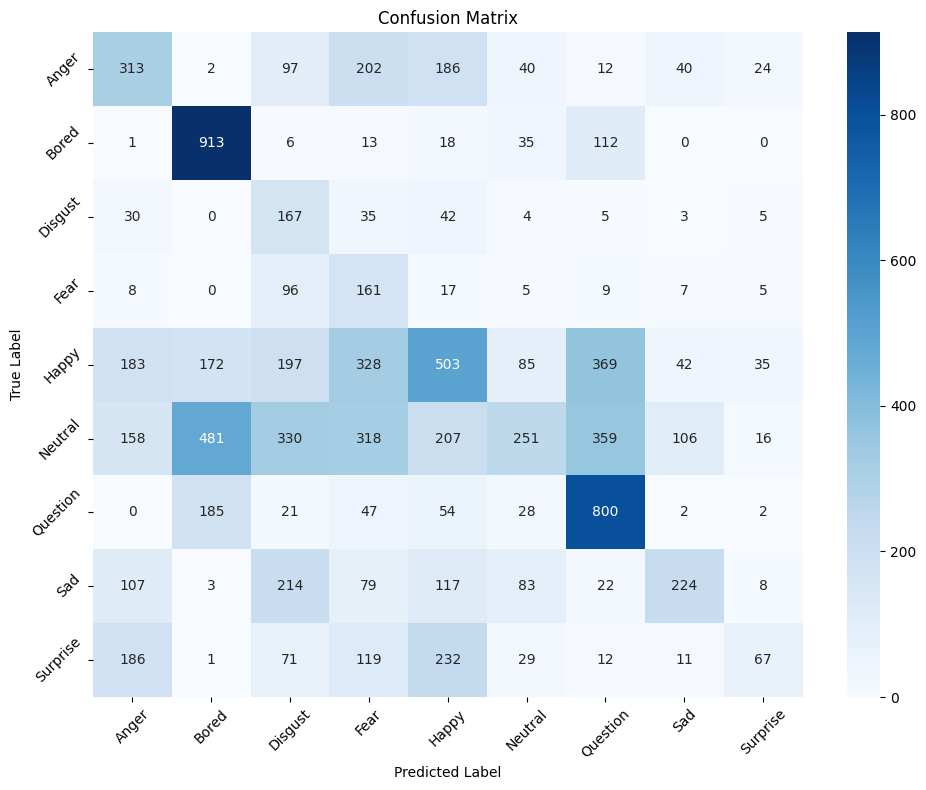

In [14]:
class_weights = torch.load(class_weights_path).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

num_classes = 9  # Adjust according to your dataset

num_features = model.fc.in_features
model.fc = nn.Linear(num_features, num_classes)

# Load the fine-tuned weights (change the filename as needed)
model.load_state_dict(torch.load(fine_tuned_weights, map_location=device))
model.to(device)

# Evaluate the model on the noisy test set
test_loss, test_accuracy, all_preds, all_labels = test(
    model, testloader, criterion, device)

# Print detailed evaluation metrics
get_evaluation_metrics(all_labels, all_preds, testset.label_map)

# Plot confusion matrix
plot_confusion_matrix(all_labels, all_preds)